### *Anaylse and Visuzalazation Sentiment Pattern in Socal Media:Twitter*

### *Dataset Introduction*
---
- This dataset contains tweets related to various topics or entities, along with sentiment analysis. The data is collected from Twitter and focuses on capturing user opinions and experiences shared via `tweets.` The tweets are categorized by sentiment, and each entry includes information about the entity being discussed. This type of dataset can be useful for analyzing public opinon, tracking brand reputation, and identifying key topics or trends.
---

 ### *Import necessary libraries*

In [874]:
# Import necessary libraries
import pandas as pd  
import numpy as np  
import re                       # For regular expressions to clean text
import matplotlib.pyplot as plt
import seaborn as sns  
from wordcloud import WordCloud  # For generating word clouds from text data
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
import warnings                        # For handling warnings in the code
warnings.filterwarnings("ignore") 

### *Load the dataset*

In [875]:
sentiment= pd.read_csv('Twitter.csv', header=None)
# Assign column names manually
sentiment.columns = ['Tweet_id','Entity', 'Sentiment',  'Tweet_Text']
sentiment.head()

,Tweet_id,Entity,Sentiment,Tweet_Text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


#### *Columns description*
*`Tweet ID:`*
    Description: A unique identifier assigned to each tweet. This ID is essential for referencing individual tweets within the dataset and for linking them to other relevant data if needed (e.g., `replies, retweets`).

*`Sentiment:`*
    Description: The sentiment classification of the tweet, which can typically be `Positive, Negative, or Neutral`. This sentiment is usually 
    determined through `natural language processing (NLP)` techniques to understand the general emotion conveyed in the tweet.

*`Entity:`*
    Description: The entity or brand being discussed in the tweet. This could refer to a *company, product, or any other notable subject*being mentioned or referenced. For example, the entity might be "Borderlands" or "Madden NFL" if the tweet is discussing a specific video game.

*`Tweet Text:`*
    Description: The full text of the tweet, which contains the user's opinion, feedback, or statement. This column allows us to perform detailed analysis, such as extracting specific keywords or phrases associated with particular sentiments or entities.

### *Data Cleaning*

In [876]:
sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Tweet_id    74682 non-null  int64 
 1   Entity      74682 non-null  object
 2   Sentiment   74682 non-null  object
 3   Tweet_Text  73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


#### *Observations*
---
- *The dataset contains:`74682` enties in total.*

- *While it contains four colomns :`Tweet_id`, ` Entity`,`Sentiment` and `Tweet_Text `. Which has been renamed.*

- *There is missing values in  `Tweet Text ` have  `73,996 non-null values.`*

---


### *Handling Missing Values*

In [877]:
# Remove rows with missing 'Tweet Text'
sentiment = sentiment.dropna(subset=['Tweet_Text'])

##### *Checking after dropping the coloumn*

In [878]:
# Verify the result by checking the data again
sentiment.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73996 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Tweet_id    73996 non-null  int64 
 1   Entity      73996 non-null  object
 2   Sentiment   73996 non-null  object
 3   Tweet_Text  73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.8+ MB


#### *Descrption* 
- *`Reasonablly minimal Data Loss:`
With only 686 missing values out of 74,682 rows, removing these rows has a minimal impact on the overall dataset size. The loss is small compared to the total amount of data, ensuring that the analysis will still be representative.*
- *filling with` unkown` will lead to misinformation that when anaylizing later will describe as` unkown `comment instead of missing values.*



#### Checking for Duplicates

In [879]:
# Check if there are any duplicate rows
print(f'Duplicated Values:', sentiment.duplicated().sum())

Duplicated Values: 2341


####  Dropping Duplicate Rows

In [880]:
# Drop duplicate rows from the DataFrame
sentiment.drop_duplicates(inplace=True)

##### *Confirmation*

In [881]:
sentiment.duplicated().sum()

0

### *Cleaning the Tweet_Text*

---
- *Tweets are typically written informally, and they may contain elements `(such as URLs, mentions, hashtags, or special characters)` that are not useful or might even interfere with the analysis of sentiment or key words. Cleaning the text ensures that we're working with a consistent format that focuses on the actual words , which improves the accuracy of sentiment analysis and other text-based tasks.*

- Example: *"Great job @johnDoe!" becomes "Great job !"*
---

In [882]:
# Function to clean text
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # Remove mentions (e.g., @username)
    text = re.sub(r'@\w+', '', text)
    
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    
    # Remove special characters and numbers, keeping only alphabets and spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Convert to lowercase
    text = text.lower()
    return text

# Apply the cleaning function and update the existing 'Tweet_Text' column
sentiment['Tweet_Text'] = sentiment['Tweet_Text'].apply(lambda x: clean_text(str(x)))

# Display the last 10 rows to confirm the updates
sentiment.tail()


,Tweet_id,Entity,Sentiment,Tweet_Text
74677,9200,Nvidia,Positive,just realized that the windows partition of my...
74678,9200,Nvidia,Positive,just realized that my mac window partition is ...
74679,9200,Nvidia,Positive,just realized the windows partition of my mac ...
74680,9200,Nvidia,Positive,just realized between the windows partition of...
74681,9200,Nvidia,Positive,just like the windows partition of my mac is l...


### *` Now we can work on the dataset `*

### *Exploratory Data Analysis*


### *Sentiment Classification of Tweet Lengths by Sentiment Category*

In [883]:
# Step 2: Get Counts for tweet lengths by sentiment
sentiment_counts= round(sentiment.groupby('Sentiment')['Tweet_Text'].count(),2)

# Display the results
print("Tweet Length Analysis by Sentiment:")
print(sentiment_counts)


Tweet Length Analysis by Sentiment:
Sentiment
Irrelevant    12537
Negative      21698
Neutral       17707
Positive      19713
Name: Tweet_Text, dtype: int64


---

#### *Observation*
---

- *Negative sentiment: **21,698** tweets*

- *Positive sentiment: **19,713** tweets*

- *Neutral sentiment: **17,707** tweets*

- *Irrelevant sentiment: **12,537** tweets*

---


#### *Remove irrelevant tweets*
---
- *Since the data have `Irrelevant sentiment` has **12,537** tweets, which might include off-topic content,Non-sentiment-related content,Empty or minimal content, spam, or tweets that do not express a clear sentiment related to the discussion.*
- *Removing irrelevant tweets ensures that the dataset is composed only of tweets that provide valuable information for sentiment analysis.*
---
 

In [884]:
# Remove rows with 'Irrelevant' sentiment directly in the existing dataset
sentiment = sentiment[sentiment['Sentiment'] != 'Irrelevant']


In [885]:
# Recalculate sentiment counts for the filtered data
sentiment_counts = sentiment['Sentiment'].value_counts()

#### *Visualization for Sentiment Distribution*

In [886]:
# Convert the counts to a DataFrame for easier plotting
sentiment_counts_df = sentiment_counts.reset_index()
sentiment_counts_df.columns = ['Sentiment', 'Count']

# Sort by 'Count' in descending order for better clarity
sentiment_counts_df = sentiment_counts_df.sort_values(by='Count', ascending=False)

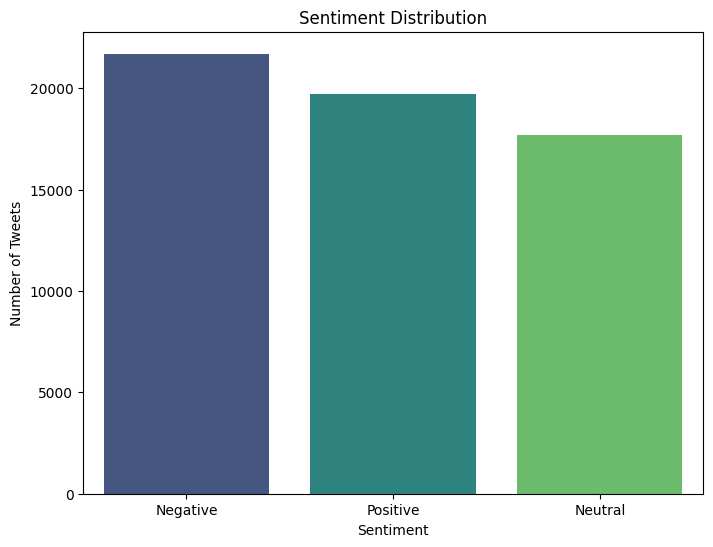

In [887]:
# Plot the sentiment distribution using Seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x='Sentiment', y='Count', data=sentiment_counts_df, palette='viridis')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=0)
plt.show()

---

####  `Interpretation of the Tweet Length Analysis by Sentiment:`
---

- *`Negative sentiment` is the most dominant category, with **21,698** tweets. This indicates that a significant number of people are sharing critical or unfavorable opinions about the topic or entity being discussed, suggesting dissatisfaction or negative feedback.*

- *`Positive sentiment` follows, with around **19,713** tweets. This shows that while there are a considerable number of supportive or favorable opinions, they are fewer than the negative sentiments, indicating mixed reactions.*

- *`Neutral sentiment` accounts for approximately **17,707** tweets. This suggests that there is a substantial amount of content where opinions are balanced or objective, focusing on neutral discussions or fact-based statements.*

---

### 

### *Generate Word Clouds for "Positive" and "Negative" Sentiments*

### *`Positive`*

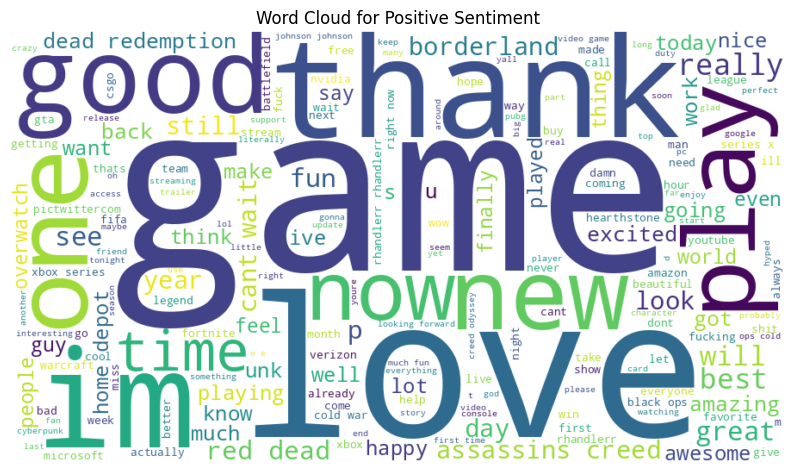

In [888]:
# Function to generate word cloud
def generate_wordcloud(sentiment_df, sentiment):
    # Combine all text in the selected sentiment group
    text = ' '.join(sentiment_df[sentiment_df['Sentiment'] == sentiment]['Tweet_Text'])
    wordcloud = WordCloud(width=900, height=500, background_color='white').generate(text)
    
    # Plot the word cloud
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {sentiment} Sentiment')
    plt.axis('off')
    plt.show()

# Generate word clouds for each sentiment type
generate_wordcloud(sentiment, 'Positive')

##### *Observation*
--- 
- *Words such as: `game`, `love`, `im`, `good`, `thank`, `play`, `new`, `great`, `really`, `now`, and `best` predominantly appear in the positive sentiment word cloud.*

#### *Interpretation*

*In the **Positive Sentiment Word Cloud**, larger words indicate higher usage frequency. The prominence of words like *"love," "game," "thank," "play,"* and *"fun"* highlights that users are sharing enthusiastic, appreciative, and enjoyable experiences. Terms such as *"amazing," "great," "good,"* and *"awesome"* further reinforce the positive tone. Additionally, popular game titles like *"Overwatch"* and *"Assassin's Creed"* frequently appear, suggesting these games are often linked with positive feedback.*

*This indicates a strong community of gamers and entertainment enthusiasts expressing satisfaction and gratitude, reflecting a positive reception of their gaming experiences.*

### *`Negative`*

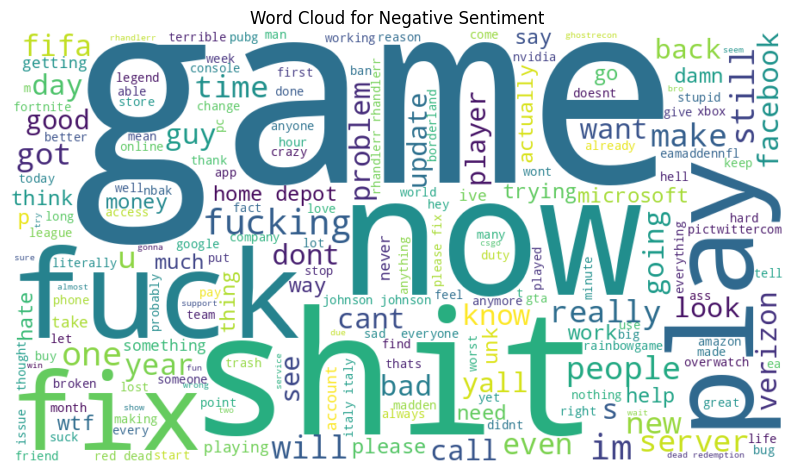

In [889]:
generate_wordcloud(sentiment, 'Negative')

##### *Observation*
---
- *Words such as `shit`, `fuck`, `fucking`, `problem`, `bad`, `hate`, `hard`, `worst`, `crazy`, `suck`, `damn`, along with `can't`, `don't`, and `terrible` are prominent in the negative sentiment word cloud. These terms reflect strong negative emotions, frustration, and dissatisfaction.*

### *Interpretation*

- *In the **Negative Sentiment Word Cloud**, the presence of words like *"fix," "server," "play,"* and *"fucking"* highlights widespread frustration, especially related to game functionality and server performance issues. Additionally, terms such as *"problem," "issue," "money,"* and *"cant"* suggest dissatisfaction with technical glitches, bugs, or potentially in-game purchases. *

- *Specific games like *"FIFA"* and companies like *"Microsoft"* are mentioned, indicating sources of user frustration. This reflects a community expressing dissatisfaction with gaming experiences, technology, and customer service, pointing to potential areas for improvement.*

## *Entity-Wise Sentiment Analysis*

In [890]:
# Get the unique values from the 'entity' column
unique_entities = sentiment['Entity'].unique()

# Display the unique entities
print(unique_entities)

['Borderlands' 'CallOfDutyBlackopsColdWar' 'Amazon' 'Overwatch'
 'Xbox(Xseries)' 'NBA2K' 'Dota2' 'PlayStation5(PS5)' 'WorldOfCraft'
 'CS-GO' 'Google' 'AssassinsCreed' 'ApexLegends' 'LeagueOfLegends'
 'Fortnite' 'Microsoft' 'Hearthstone' 'Battlefield'
 'PlayerUnknownsBattlegrounds(PUBG)' 'Verizon' 'HomeDepot' 'FIFA'
 'RedDeadRedemption(RDR)' 'CallOfDuty' 'TomClancysRainbowSix' 'Facebook'
 'GrandTheftAuto(GTA)' 'MaddenNFL' 'johnson&johnson' 'Cyberpunk2077'
 'TomClancysGhostRecon' 'Nvidia']


#### *Description*
---
#### *Breakdown of Unique Column Values*
### *Video Games*
- ***First-Person Shooters***:  
  - *This category includes popular titles such as 'Borderlands', 'CallOfDutyBlackopsColdWar', 'CS-GO', 'Battlefield', 'CallOfDuty', 'TomClancysRainbowSix', 'TomClancysGhostRecon'.*  
  - *These games typically attract discussions around gameplay mechanics, graphics, and online multiplayer experiences.*

- ***Role-Playing Games (RPGs)***:  
  - *Games like 'Cyberpunk2077', 'AssassinsCreed', 'RedDeadRedemption(RDR)', 'GrandTheftAuto(GTA)' fall under this category.*  
  - *Feedback here often focuses on storyline depth, character development, and immersive worlds.*

- ***Sports Games***:  
  - *Titles such as 'NBA2K', 'FIFA', 'MaddenNFL' are prevalent in this category.*  
  - *Users may discuss aspects like realism, player updates, and game physics.*

- ***Multiplayer Online Battle Arena (MOBA)***:  
  - *Popular games include 'Dota2', 'LeagueOfLegends'.*  
  - *Topics may involve strategy, team coordination, and updates to gameplay balance.*

- ***Battle Royale Games***:  
  - *This includes highly engaging titles like 'ApexLegends', 'Fortnite', 'PlayerUnknownsBattlegrounds(PUBG)'.*  
  - *Conversations often center on game updates, seasonal events, and competitive play.*

- ***Others***:  
  - *This category includes games like 'Overwatch', 'WorldOfCraft', 'Hearthstone' which span across various genres and fan communities.*

### *Gaming Platforms*
- *Platforms such as 'Xbox(Xseries)' and 'PlayStation5(PS5)' are highlighted.*  
  - *Users may share their experiences related to hardware performance, exclusive titles, and platform services.*

### *Technology and Service Providers*
- *Major tech companies like 'Google', 'Microsoft', 'Verizon', 'Nvidia', 'Amazon', 'Facebook', 'HomeDepot' appear frequently.*  
  - *These entries suggest discussions related to tech services, product updates, or customer support issues.*

### *Pharmaceutical and Consumer Goods*
- *The presence of 'johnson&johnson' indicates mentions related to healthcare or consumer products.*  
  - *This could imply customer feedback, product reviews, or service-related discussions.*


##### *Conclusion*:  
- *The data suggests that users are actively discussing their experiences related to video `games`,` tech products`, `and services`, as well as interactions with certain consumer goods brands. This information can be leveraged to better understand customer sentiment, enhance user engagement strategies, or address specific concerns raised by your audience.*

- *These names represent Video Games, Gaming Platforms, and Technology and Service Providers that have significant influence in the world of gaming, technology, and entertainment.*

---

### *Visulizing Attitudes towards the :Brands,Games,Platforms*

<Figure size 1000x600 with 0 Axes>

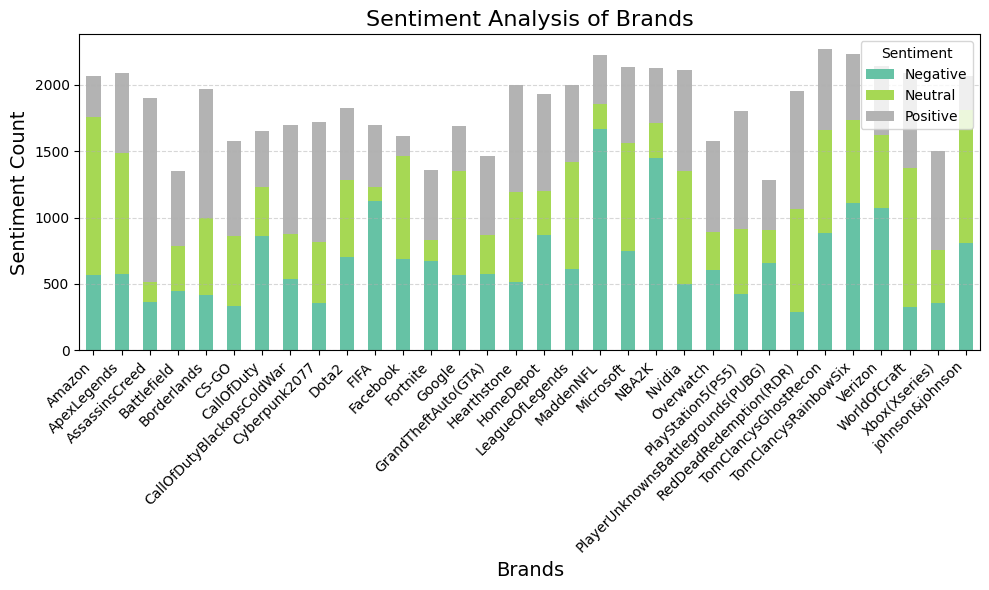

In [ ]:
# Reset the index to flatten the grouped DataFrame
sentiment_counts = sentiment.groupby(['Entity', 'Sentiment']).size().reset_index(name='Count')

# Pivot the data to have 'Sentiment' as columns for stacking
sentiment_pivot = sentiment_counts.pivot(index='Entity', columns='Sentiment', values='Count').fillna(0)

# Plotting the stacked bar chart
plt.figure(figsize=(10, 6))
sentiment_pivot.plot(
    kind='bar',
    stacked=True,
    colormap='Set2',
    figsize=(10, 6)
)

# Adding labels and title
plt.title('Sentiment Analysis of Brands', fontsize=16)
plt.xlabel('Brands', fontsize=14)
plt.ylabel('Sentiment Count', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend(title='Sentiment', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Display the plot
plt.tight_layout()
plt.show()
S